In [1]:
'''
Samuel Grant 2024

Read failure events and make plots. 

Based on PlotFailures.py. Better suited to notebook (so we don't have to load the data each time). 

''' 

"\nSamuel Grant 2024\n\nRead failure events and make plots. \n\nBased on PlotFailures.py. Better suited to notebook (so we don't have to load the data each time). \n\n"

In [16]:
# External libraries
import numpy as np
import pandas as pd
import awkward as ak
import uproot

# Internal libraries
sys.path.append(os.path.abspath("../PyMacros"))
import Utils as ut
%run PlotFitUtils.ipynb
from Mu2eEAF import ReadData as rd 

In [3]:
# Get file list
fileListPath="../Txt/FileLists/MDC2020aeOnExpData.txt"
def ReadFileList(fileListPath):
  with open(fileListPath, "r") as fileList_:
    lines = fileList_.readlines()
    lines = [line.strip() for line in lines]  # Remove leading/trailing whitespace
  return lines
fileList_=ReadFileList(fileListPath)
print(f"---> {len(fileList_)} files in list.")

---> 96 files in list.


In [11]:
'''
Get failure info
For each file, collect the events. 

This takes quite a while (2-3 minutes maybe).
I spent a full day trying to multithread this, it blows up my memory. 
'''
def GetFailures(fileList_, PEs=10, layers="3", particle="all", cut="singles"):

     # Collect failure info
    failureFilePath = f"../Txt/MDC2020ae/concatenated/failures_concise/failures_concise_all_{PEs}PEs{layers}Layers_{cut}.csv"

    print(f"\n---> Using info file {failureFilePath}.")
    failureInfo_ = pd.read_csv(failureFilePath)

    # Collect file list
    tags_ = list(set(failureInfo_["tag"]))
    
    # Extract the tag from the file name
    def ExtractTag(fileName):
        parts = fileName.split('.')
        if len(parts) > 1:
            return parts[-2]
        return None

    # Filter and sort files based on tags
    fileList_ = sorted(
        [file for file in fileList_ if ExtractTag(file) in tags_]
        , key=lambda file: tags_.index(ExtractTag(file))
    )

    # testing
    # tags_ = tags_[:1]
    # fileList_ = fileList_[:1]
    
    # Bug check
    if len(fileList_) == len(tags_):
        print("\n---> Collected and sorted failure file names.")
    else:
        raise Exception("\n---> len(fileList_) != len(tags_)")

    completedFiles = 0
    totalFiles = len(fileList_)

    print(f"\n---> Iterating through {len(fileList_)} files.\n") 

    # Master array to hold results
    data_ = ak.Array([])
    
    # Iterate through file list.
    for tag, fileName in zip(tags_, fileList_): 
    
        # Find failure events
        thisFailureInfo_ = failureInfo_[failureInfo_["tag"] == tag]
        outputStr = ( 
            f"\n--->\n" 
            f"fileName: {fileName}\n"
            f"tag: {tag}\n"
            f"failures:\n{thisFailureInfo_}\n"
            f"---"
        )
        if False: print(outputStr)
    
        # Read the file
        with uproot.open(fileName) as file: 
            
            # file = (fileName, quiet=True)
            # Get array
            thisData_ = ut.GetData(file)
        
            if False: print(f"\n---> Loaded corresponding data.\n{thisData_}")
                
            if False: print(f"\n---> Applying masks.")
        
            # Extract unique values from DataFrame
            runs_ = set(thisFailureInfo_["evtinfo.run"])
            subruns_ = set(thisFailureInfo_["evtinfo.subrun"])
            events_ = set(thisFailureInfo_["evtinfo.event"])
        
            # Construct masks
            runCondition = ak.any([thisData_["evt"]["evtinfo.run"] == value for value in runs_], axis=0)
            subrunCondition = ak.any([thisData_["evt"]["evtinfo.subrun"] == value for value in subruns_], axis=0)
            eventCondition = ak.any([thisData_["evt"]["evtinfo.event"] == value for value in events_], axis=0)
        
            # Apply masks
            thisData_ = thisData_[runCondition & subrunCondition & eventCondition]
        
            # Append to master array
            if False: print(f"\n---> Appending failures to master array.")
            data_ = ak.concatenate([data_, thisData_], axis=0)

            if False:
                print(thisFailureInfo_)
                ut.PrintNEvents(data_)
    
            completedFiles += 1
            percentComplete = (completedFiles / totalFiles) * 100
            
            print(f"\r---> Processed {fileName} ({percentComplete:.1f}% complete...)", end="") 

    inputEventList = failureInfo_["evtinfo.event"]
    outputEventList = ak.flatten(data_["evt"]["evtinfo.event"], axis=None)

    return data_
    
    # # print(outputEventList)
    # # ut.PrintNEvents(data_)

    # if len(inputEventList) == len(outputEventList):
    #     print("data_ contains the correct number of events!")
    #     print("Done!")
    #     print(len(inputEventList), len(outputEventList))
    #     return data_
    # else:
    #     raise ValueError(f"data_ contains the wrong number of events! {len(outputEventList)} compared with {len(inputEventList)}.")

In [12]:
# Parameters
PEs=10
layers="3"
particle="all"

In [13]:
data_singles_ = GetFailures(fileList_, PEs=PEs, layers=layers, particle=particle, cut="singles")
# ut.PrintNEvents(data_singles_, 1);


---> Using info file ../Txt/MDC2020ae/concatenated/failures_concise/failures_concise_all_10PEs3Layers_singles.csv.

---> Collected and sorted failure file names.

---> Iterating through 36 files.

---> Processed /exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00056/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000024.root (100.0% complete...)

In [14]:
data_singles_track_cuts_ = GetFailures(fileList_, PEs=PEs, layers=layers, particle=particle, cut="singles_track_cuts")


---> Using info file ../Txt/MDC2020ae/concatenated/failures_concise/failures_concise_all_10PEs3Layers_singles_track_cuts.csv.

---> Collected and sorted failure file names.

---> Iterating through 9 files.

---> Processed /exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/81168767/00/00000/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000014.root (100.0% complete...)

In [ ]:
# ut.PrintNEvents(data_singles_, 1);
# ut.PrintNEvents(data_singles_track_cuts_, 1);

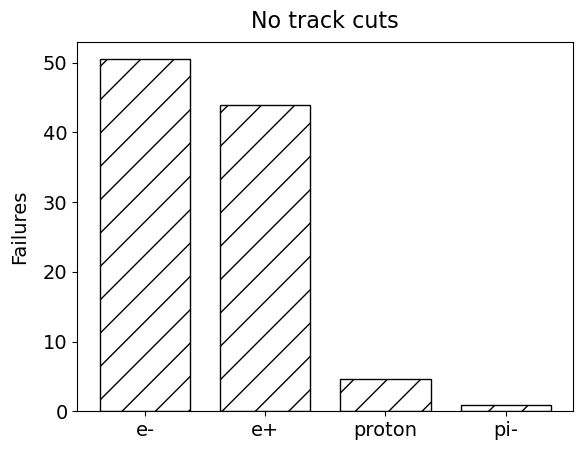

---> Written ../Images/MDC2020ae/Failures/bar_pdgid_singles.png


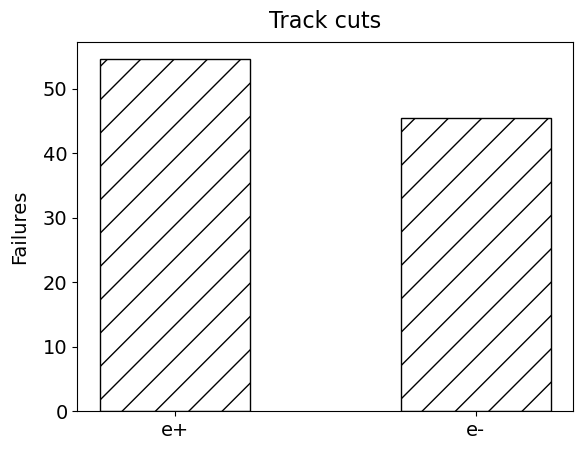

---> Written ../Images/MDC2020ae/Failures/bar_pdgid_singles_track_cuts.png


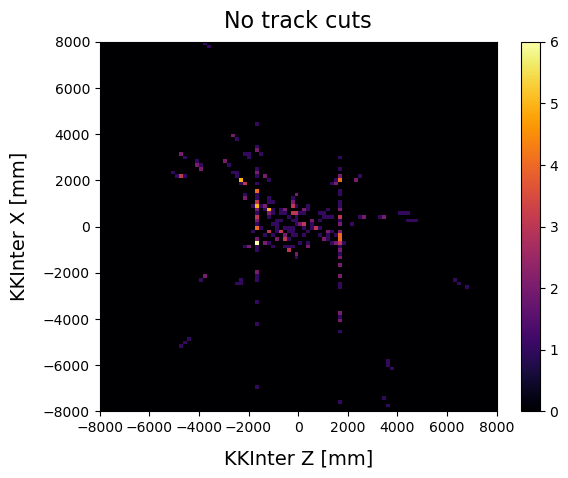


---> Written:
	 ../Images/MDC2020ae/Failures/h2_ZX_singles.png


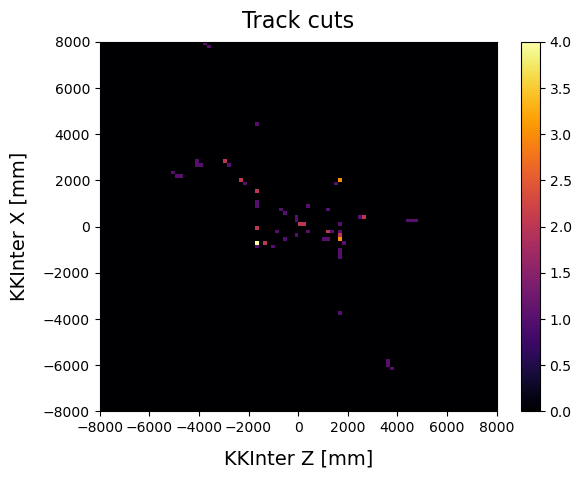


---> Written:
	 ../Images/MDC2020ae/Failures/h2_ZX_singles_track_cuts.png


In [19]:
# Now we have the failure data...
# Plot it here...
BarChart(ak.flatten(data_singles_["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title="No track cuts",  ylabel="Failures", fout=f"../Images/MDC2020ae/Failures/bar_pdgid_singles.png", percentage=True)

BarChart(ak.flatten(data_singles_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title="Track cuts", ylabel="Failures", fout=f"../Images/MDC2020ae/Failures/bar_pdgid_singles_track_cuts.png", percentage=True)

# Plot1D(ak.flatten(data_singles_["crv"]["crvcoincsmc.primaryE"], axis=None)
#        , nbins=100, xmin=0, xmax=1e5
#        , underOver=True
#        , title="No track cuts", xlabel="Primary energy [eV/c?]", ylabel="Failures"
#        , fout="../Images/MDC2020ae/Failures/h1_primaryE_singles.png")

# Plot1D(ak.flatten(data_singles_track_cuts_["crv"]["crvcoincsmc.primaryE"], axis=None)
#        , nbins=100, xmin=0, xmax=1e5
#        , underOver=True
#        , title="Track cuts", xlabel="Primary energy [eV/c?]", ylabel="Failures"
#        , fout="../Images/MDC2020ae/Failures/h1_primaryE_singles.png")

# Maybe indicates that the track cuts aren't complete. 
# Ah, I probably need to enforce the fiducial area cut...

Plot2D(x=ak.flatten(data_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(data_singles_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       , title="No track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout="../Images/MDC2020ae/Failures/h2_ZX_singles.png")

Plot2D(x=ak.flatten(data_singles_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(data_singles_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       , title="Track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout="../Images/MDC2020ae/Failures/h2_ZX_singles_track_cuts.png")



# print(data_singles_track_cuts_["trkfit"]["klfit"])


In [ ]:
# # What is more interesting is those that pass the singles cut, but not the track cut.
# # Although, this good be biased a bit because sometimes the track cuts generate an exception, while the singles do not!
# # Need to ID a file where this doesn't happen. (See ../Scripts/FindGoodFiles.sh)
# # 79 good files, written tags to ../Txt/MDC2020ae/GoodFiles/good_files.csv

# goodFileTags_ = ReadFileList("../Txt/MDC2020ae/GoodFiles/good_files.csv")

# # Make a dataframe for singles and singles_track_cuts using these files. 
# def CollectGoodFiles(goodFileTags_, PEs="10", layer="3", particle="all", cut="singles"):
#     baseDir=f"../Txt/MDC2020ae/failures_concise"
#     data_ = pd.DataFrame()
#     tasks = len(goodFileTags_)
#     completedTasks = 1
#     for i, goodFileTag in enumerate(goodFileTags_):
#         if i == 0: continue # skip header
#         goodFile = f"{baseDir}/{goodFileTag}/failures_concise_{particle}_{PEs}PEs{layer}Layers_{cut}.csv"
#         thisData_ = pd.read_csv(goodFile)
#         # Append data to the main DataFrame without resetting the index
#         if thisData_ is not None: 
#             # Add the tag to the first column
#             thisData_.insert(0, "Tag", goodFileTag)
#             # Concatenate
#             data_ = pd.concat([data_, thisData_], ignore_index=True)
#         completedTasks += 1
#         percentComplete = (completedTasks / tasks) * 100
#         print(f"\r---> Processed {goodFileTag} ({percentComplete:.1f}% complete...)", end="") 
#     return data_

# data_singles_ = CollectGoodFiles(goodFileTags_, PEs=10, cut="singles")
# data_singles_track_cuts_ = CollectGoodFiles(goodFileTags_, PEs=10, cut="singles_track_cuts")

# print(f"\n---> data_singles_:\n{data_singles_}")
# print(f"\n---> data_singles_track_cuts_:\n{data_singles_track_cuts_}")

In [ ]:
# # Now find entries unique to singles_track_cuts_ 
# # Merge DataFrames with an left join to get rows unique to singles_
# # I run the singles filter before the track cuts filter. 
# # This means that some events will pass the singles filter, and then be removed by the track cuts filter.
# # These events are unique to singles. 
# # We can look at the in the event display to see what happens in these cases. 

# # We need events which pass the singles cut but are then removed by the track cuts. 
# # These are actually not present in any of the failure samples, because these just contain failures. 
# # Unfortunately I do not put any marker on the ones removed by the tracker cuts, I just through them out. 

# # Merge
# data_merged_ = pd.merge(data_singles_, data_singles_track_cuts_, how="left", indicator=True)
# # Find unique to singles events
# unique_to_singles_ = data_merged_[data_merged_['_merge'] == 'left_only']
# # Drop the _merge column
# unique_to_singles_ = unique_to_singles_.drop('_merge', axis=1)
# print(unique_to_singles_)

In [ ]:
# Run it again?